In [1]:

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm

import scipy as sp
sp.__version__

/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'0.19.1'

In [59]:
X_train_color = []
y_train_color = []
X_test_color = []
import os
d = os.listdir('train/')

for fname in d:
    if fname.find('indoor'):
        X_train_color.append(sp.misc.imread('train/'+fname))
        y_train_color.append(0)
    else:
        X_train_color.append(sp.misc.imread('train/'+fname))
        y_train_color.append(1)

d = os.listdir('test/')
for fname in d:
    X_test_color.append(sp.misc.imread('test/'+fname))

X_train_color = np.array(X_train_color)
y_train_color = np.array(y_train_color)
X_test_color = np.array(X_test_color)
print(X_test_color.shape[0])

2960


In [78]:
print(X_train_color.shape)
print(X_train_color[0][:,:,0])
X_train_color_flattened = []
for x in X_train_color:
    #print(x.shape)
    X_train_color_flattened.append(np.vstack([x[:,:,0].flatten(),x[:,:,1].flatten(), x[:,:,2].flatten()]).T)
print(X_train_color_flattened[0].shape)
X_train_color_flattened = np.array(X_train_color_flattened)
R = X_train_color_flattened[:, :, 0]
G = X_train_color_flattened[:, :, 1]
B = X_train_color_flattened[:, :, 2]
#X_train_bw = R * 299/1000 + G * 587/1000 + B * 114/1000
X_train_bw = np.hstack([R, G, B])
print(X_train_bw.shape)

(6905, 32, 32, 3)
[[174 166 151 ...,  45  42  38]
 [187 179 167 ...,  52  49  48]
 [179 175 168 ...,  57  54  52]
 ..., 
 [ 34  42  39 ...,  63  59  56]
 [ 26  39  44 ...,  56  56  53]
 [ 68  37  45 ...,  60  48  48]]
(1024, 3)
(6905, 3072)


In [80]:

X_test_color_flattened = []
for x in X_test_color:
    #print(x.shape)
    X_test_color_flattened.append(np.vstack([x[:,:,0].flatten(),x[:,:,1].flatten(), x[:,:,2].flatten()]).T)
print(X_test_color_flattened[0].shape)
X_test_color_flattened = np.array(X_test_color_flattened)
R = X_test_color_flattened[:, :, 0]
G = X_test_color_flattened[:, :, 1]
B = X_test_color_flattened[:, :, 2]
#X_test_bw = R * 299/1000 + G * 587/1000 + B * 114/1000
X_test_bw = np.hstack([R, G, B])
print(X_test_bw.shape)

(1024, 3)
(2960, 3072)


In [81]:
from sklearn.metrics import log_loss
class LR:
    def get_Xn(self, X):
        return np.hstack((X, np.ones(X.shape[0]).reshape(-1,1)))
    
    def fit(self, X_train, Y_train, X_test, Y_test, itrs=5000, step=1000, report_cost=False, reg=0, 
            armijo=False, alpha=0.5, beta=0.5):
        Xn = self.get_Xn(X_train)
        
        self.reg=reg
        
        self.K = Y_train.shape[1] if len(Y_train.shape) > 1 else 1
        self.W = np.zeros((self.K, Xn.shape[1])) 
        #self.W = np.random.uniform(-0.1, 0.1, (Y_train.shape[1], Xn.shape[1]))
        
        train_loss = []
        test_loss = []
        self.step_stats = dict()
        for i in tqdm.tqdm_notebook(range(itrs)):
            grad = self.grad(Xn, Y_train, self.W)
            if armijo == True:
                s = self.armijo(self.W, X_train, Y_train, grad, step, alpha=alpha, beta=beta)
            else:
                s = step
            self.W = self.W - s*grad
            
            if report_cost:
                train_loss.append(self.loss(X_train, Y_train))
                test_loss.append(self.loss(X_test, Y_test))
        
        return np.array(train_loss), np.array(test_loss)
    
    def softmax(self, W):
        """Вычисляет softmax от произвольной матрицы W"""
        # Чтобы при промежуточных операциях (суммировании e^z) не возникло переполнения, 
        # используем logsumexp, пытаясь сделать все операции с логарифмами, 
        # и только потом возвести e в степень.
        good = np.exp(W - sp.misc.logsumexp(W, axis=1).reshape(-1,1))
        # Впрочем, ни разу во время тестовых запусков следующий ассерт не сработал.
        #tmp = np.exp(W)
        #bad = tmp / np.sum(tmp, axis=1).reshape((-1,1))
        #assert((np.isclose(bad, good)).all())
            
        return good
    
    def predict(self, X, W=None):
        """Предсказывает значения по выборке. Возвращает вероятности принадлежности тому или иному классу"""
        if W is None:
            W = self.W
        Xn = self.get_Xn(X)
        return self.softmax(np.dot(Xn, W.T))
    
    def grad(self, Xn, Y, W):
        X = Xn[:, :-1]
        Yh = self.softmax(np.dot(Xn, W.T))
        gradient = np.dot(Yh.T-Y.T,Xn)/Xn.shape[0] + self.reg*W
        # Проверка градиента на правильность. Всё хорошо.
        #assert(sp.optimize.check_grad(lambda W: self.loss(X, Y, W=W.reshape(10, 65)), 
        #                            lambda W: np.dot(self.softmax(np.dot(Xn, W.reshape(10, 65).T)).T-Y.T,Xn).flatten()/Xn.shape[0], 
        #                            W.flatten()) < 1e-5)
        return gradient
    
    def armijo (self, W, X, Y, dW, s, alpha, beta):
        while True:
            deltaW = -dW
            f_new = self.loss(X, Y, W=(W+s*deltaW))
            f_old = self.loss(X, Y, W=(W))
            move = alpha*s*(deltaW*dW).sum()

            if f_new <= f_old+move:
                break
            s = beta*s

        #print('s=', s)
        if s not in self.step_stats:
            self.step_stats[s] = 0
        self.step_stats[s] += 1
        return s
    
    def cross_entropy(self, Y_t, Y_p):
        return -np.sum(np.mean(Y_t*np.log(Y_p), axis=0), axis=0)
    
    def loss(self, X, Y, W=None):
        if W is None:
            W = self.W
        Y_p = self.predict(X, W=W)
        #print(log_loss(Y, Y_p), self.cross_entropy(Y, Y_p) - self.reg*np.trace(np.dot(W, W.T))/W.shape[0])
        #assert(np.isclose(log_loss(Y, Y_p), self.cross_entropy(Y, Y_p) - self.reg*np.trace(np.dot(W, W.T))/W.shape[0]))
        # Или +?
        return self.cross_entropy(Y, Y_p) + self.reg*np.trace(np.dot(W, W.T))/W.shape[0]
    

In [82]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

X_train_big = (X_train_bw-128)/256
y_train_big = one_hot(y_train_color, 2)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_big,
    one_hot(y_train_color, 2),
    test_size=0.33,
    random_state=0
)

HBox(children=(IntProgress(value=0), HTML(value='')))


Armijo = True
Error rate on train: 0.238218763511
Error rate on test: 0.286529179465
Argmin loss on train: 99
Argmin loss on test: 98


HBox(children=(IntProgress(value=0), HTML(value='')))


Armijo = True
Error rate on train: 0.238002594034
Error rate on test: 0.285212812637
Argmin loss on train: 99
Argmin loss on test: 84


HBox(children=(IntProgress(value=0), HTML(value='')))


Armijo = True
Error rate on train: 0.239083441418
Error rate on test: 0.286090390522
Argmin loss on train: 99
Argmin loss on test: 56


HBox(children=(IntProgress(value=0), HTML(value='')))


Armijo = True
Error rate on train: 0.238434932987
Error rate on test: 0.286967968407
Argmin loss on train: 99
Argmin loss on test: 96
{0.0015625: 4, 0.003125: 48, 0.025: 18, 0.0125: 4, 0.05: 8, 0.1: 5, 0.2: 13}


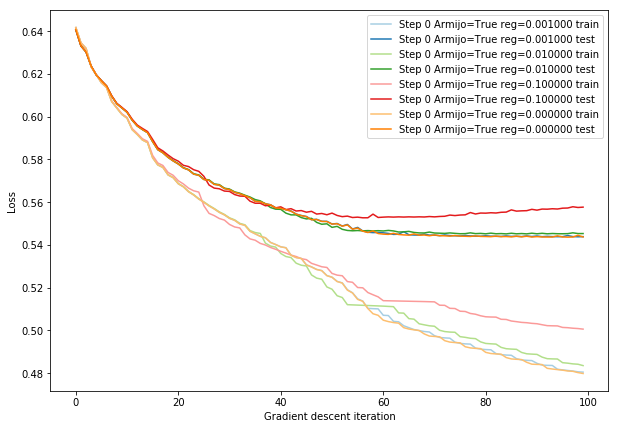

In [83]:
lr = LR()

def error_rate(Y_t, Y_p):
    if len(Y_t.shape)>1:
        return np.sum( np.not_equal(np.argmax(Y_t,axis=1), np.argmax(Y_p,axis=1))) / float(Y_p.shape[0])
    else:
        return np.sum( np.not_equal(np.argmax(Y_t), np.argmax(Y_p))) / float(Y_p.shape[0])

def run_and_report(armijo, itrs, step, reg=0):
    loss_train, loss_test = lr.fit(X_train, y_train, X_test, y_test, report_cost=True, 
                                                 itrs=itrs, step=step, armijo=armijo, reg=reg)
    print('Armijo =', armijo)
    print('Error rate on train:', error_rate(y_train, lr.predict(X_train)))
    print('Error rate on test:', error_rate(y_test, lr.predict(X_test)))
    
    cm = plt.cm.get_cmap('Paired')
    plt.plot(
        loss_train, 
        color=cm(plt.cmap_index),
        label='Step %d Armijo=%s reg=%f train'%(step, armijo, reg)
    )
    plt.cmap_index += 1
    
    plt.plot(
        loss_test,
        color=cm(plt.cmap_index),
        label='Step %d Armijo=%s reg=%f test'%(step, armijo, reg)
        )
    plt.cmap_index += 1

    plt.xlabel('Gradient descent iteration')
    plt.ylabel('Loss')
    plt.legend()
    
    print('Argmin loss on train:', np.argmin(loss_train))
    print('Argmin loss on test:', np.argmin(loss_test))
    
    return loss_train, loss_test

plt.figure(figsize=(10, 7))
plt.cmap_index = 0
loss_train, loss_test = run_and_report(True, 100, 0.2, reg=0.001)
loss_train, loss_test = run_and_report(True, 100, 0.2, reg=0.01)
loss_train, loss_test = run_and_report(True, 100, 0.2, reg=0.1)
loss_train, loss_test = run_and_report(True, 100, 0.2, reg=0)
#loss_train, loss_test = run_and_report(True, 1000, 0.2, reg=0)
print(lr.step_stats)
#print(loss_train, loss_test)
plt.show()

In [ ]:
print(lr.predict(X_train)[:, 0] == y_train)
print(y_train)

In [91]:
lr.fit(X_train_big, y_train_big, [], [], report_cost=False, itrs=100, armijo=True, step=0.5)
y_p_prob = lr.predict(X_test_bw)
y_p = np.argmax(y_p_prob, axis=1)

HBox(children=(IntProgress(value=0), HTML(value='')))

In [92]:
y_p = np.argmax(y_p_prob, axis=1)
print(y_p.sum(), y_p.shape[0])

2055 2960


In [94]:
with open('out.csv', 'w') as f:
    f.write('id,res\n')
    for i, ans in enumerate(y_p):
        f.write('%s,%s\n'%(i,ans))